In [1]:
%matplotlib inline
# -*- coding: utf-8 -*-
"""
Created on Fri Apr 22 17:25:13 2016

@author: tabacof
"""

# Implements a variational autoencoder as described in Kingma et al. 2013
# "Auto-Encoding Variational Bayes"
import theano
theano.config.floatX = 'float32'
import theano.tensor as T
import numpy as np
import lasagne
from parmesan.distributions import log_bernoulli, kl_normal2_stdnormal
from parmesan.layers import SimpleSampleLayer
from parmesan.datasets import load_mnist_binarized
import time, shutil, os
import scipy
from scipy.io import loadmat
import matplotlib
import pylab as plt
from read_write_model import read_model, write_model

Using gpu device 1: GeForce GTX 980 (CNMeM is disabled, cuDNN 4007)


In [2]:
#settings
do_train_model = True
batch_size = 100
latent_size = 20
nhidden = 1024
lr = 0.0002
num_epochs = 25
model_filename = "mnist_ae"
nonlin = lasagne.nonlinearities.rectify

np.random.seed(1234) # reproducibility

In [3]:
#SYMBOLIC VARS
sym_x = T.matrix()
sym_lr = T.scalar('lr')

### LOAD DATA
print "Using MNIST dataset"

train_x, valid_x, test_x = load_mnist_binarized()

train_x = np.concatenate([train_x, valid_x])

train_x = train_x.astype(theano.config.floatX)
test_x = test_x.astype(theano.config.floatX)

#setup shared variables
sh_x_train = theano.shared(train_x, borrow=True)
sh_x_test = theano.shared(test_x, borrow=True)

nfeatures=train_x.shape[1]
n_train_batches = train_x.shape[0] / batch_size
n_test_batches = test_x.shape[0] / batch_size

Using MNIST dataset


In [4]:
### RECOGNITION MODEL q(z|x)
l_in = lasagne.layers.InputLayer((batch_size, nfeatures))
l_noise = lasagne.layers.BiasLayer(l_in, b = np.zeros(nfeatures, dtype = np.float32), name = "NOISE")
l_noise.params[l_noise.b].remove("trainable")
l_enc_h1 = lasagne.layers.DenseLayer(l_noise, num_units=nhidden, nonlinearity=nonlin, name='ENC_DENSE1')
l_enc_h1 = lasagne.layers.DenseLayer(l_enc_h1, num_units=nhidden, nonlinearity=nonlin, name='ENC_DENSE2')

l_z = lasagne.layers.DenseLayer(l_enc_h1, num_units=latent_size, nonlinearity=lasagne.nonlinearities.identity, name='Z')

In [5]:
### GENERATIVE MODEL p(x|z)
l_dec_h1 = lasagne.layers.DenseLayer(l_z, num_units=nhidden, nonlinearity=nonlin, name='DEC_DENSE2')
l_dec_h1 = lasagne.layers.DenseLayer(l_dec_h1, num_units=nhidden, nonlinearity=nonlin, name='DEC_DENSE1')
l_dec_x = lasagne.layers.DenseLayer(l_dec_h1, num_units=nfeatures, nonlinearity=lasagne.nonlinearities.sigmoid, name='DEC_X_MU')

dec_x = lasagne.layers.get_output(l_dec_x, sym_x, deterministic=False)

In [6]:
loss = lasagne.objectives.squared_error(dec_x, sym_x.reshape((batch_size, -1)))
loss = lasagne.objectives.aggregate(loss, mode="mean")

params = lasagne.layers.get_all_params(l_dec_x, trainable=True)
for p in params:
    print p, p.get_value().shape

### Take gradient of Negative LogLikelihood
grads = T.grad(loss, params)

# Add gradclipping to reduce the effects of exploding gradients.
# This speeds up convergence
clip_grad = 1
max_norm = 5
mgrads = lasagne.updates.total_norm_constraint(grads,max_norm=max_norm)
cgrads = [T.clip(g,-clip_grad, clip_grad) for g in mgrads]

ENC_DENSE1.W (784, 1024)
ENC_DENSE1.b (1024,)
ENC_DENSE2.W (1024, 1024)
ENC_DENSE2.b (1024,)
Z.W (1024, 20)
Z.b (20,)
DEC_DENSE2.W (20, 1024)
DEC_DENSE2.b (1024,)
DEC_DENSE1.W (1024, 1024)
DEC_DENSE1.b (1024,)
DEC_X_MU.W (1024, 784)
DEC_X_MU.b (784,)


In [7]:
#Setup the theano functions
sym_batch_index = T.iscalar('index')
batch_slice = slice(sym_batch_index * batch_size, (sym_batch_index + 1) * batch_size)

updates = lasagne.updates.adam(cgrads, params, learning_rate=sym_lr)

train_model = theano.function([sym_batch_index, sym_lr], loss, updates=updates,
                                  givens={sym_x: sh_x_train[batch_slice]},)

test_model = theano.function([sym_batch_index], loss,
                                  givens={sym_x: sh_x_test[batch_slice]},)

plot_results = theano.function([sym_batch_index], dec_x,
                                  givens={sym_x: sh_x_test[batch_slice]},)

def train_epoch(lr):
    costs = []
    for i in range(n_train_batches):
        cost_batch = train_model(i, lr)
        costs += [cost_batch]
    return np.mean(costs)


def test_epoch():
    costs = []
    for i in range(n_test_batches):
        cost_batch = test_model(i)
        costs += [cost_batch]
    return np.mean(costs)

In [8]:
if do_train_model:
    # Training Loop
    for epoch in range(num_epochs):
        start = time.time()

        #shuffle train data, train model and test model
        np.random.shuffle(train_x)
        sh_x_train.set_value(train_x)
            
        train_cost = train_epoch(lr)
        test_cost = test_epoch()

        t = time.time() - start

        line =  "*Epoch: %i\tTime: %0.2f\tLR: %0.5f\tLL Train: %0.3f\tLL test: %0.3f\t" % ( epoch, t, lr, train_cost, test_cost)
        print line
    
    print "Write model data"
    write_model(l_dec_x, model_filename)
else:
    read_model(l_dec_x, model_filename)

*Epoch: 0	Time: 12.44	LR: 0.00020	LL Train: 0.056	LL test: 0.034	
*Epoch: 1	Time: 12.38	LR: 0.00020	LL Train: 0.032	LL test: 0.030	
*Epoch: 2	Time: 12.28	LR: 0.00020	LL Train: 0.029	LL test: 0.028	
*Epoch: 3	Time: 12.31	LR: 0.00020	LL Train: 0.028	LL test: 0.027	
*Epoch: 4	Time: 12.68	LR: 0.00020	LL Train: 0.027	LL test: 0.026	
*Epoch: 5	Time: 12.88	LR: 0.00020	LL Train: 0.026	LL test: 0.026	
*Epoch: 6	Time: 12.04	LR: 0.00020	LL Train: 0.025	LL test: 0.025	
*Epoch: 7	Time: 12.39	LR: 0.00020	LL Train: 0.025	LL test: 0.025	
*Epoch: 8	Time: 12.44	LR: 0.00020	LL Train: 0.024	LL test: 0.025	
*Epoch: 9	Time: 12.52	LR: 0.00020	LL Train: 0.024	LL test: 0.025	
*Epoch: 10	Time: 13.14	LR: 0.00020	LL Train: 0.024	LL test: 0.024	
*Epoch: 11	Time: 12.56	LR: 0.00020	LL Train: 0.023	LL test: 0.024	
*Epoch: 12	Time: 12.76	LR: 0.00020	LL Train: 0.023	LL test: 0.024	
*Epoch: 13	Time: 11.95	LR: 0.00020	LL Train: 0.023	LL test: 0.024	
*Epoch: 14	Time: 12.16	LR: 0.00020	LL Train: 0.023	LL test: 0.024	
*Epoc

In [9]:
def show_mnist(img, i, title=""): # expects flattened image of shape (3072,) 
    img = img.copy().reshape(28, 28)
    img = np.clip(img, 0, 1)
    plt.subplot(3, 2, i)
    plt.imshow(img, cmap='Greys_r')
    plt.title(title)
    plt.axis("off")
    
def mnist_input(img):
    return np.tile(img, (batch_size, 1, 1, 1)).reshape(batch_size, 784)

def mnist_dist(img1, img2):
    return np.linalg.norm(img1 - img2)

In [10]:
l_z, reconstruction = lasagne.layers.get_output([l_z, l_dec_x], inputs = sym_x, deterministic=True)
# Adversarial confusion cost function
    
# Mean squared reconstruction difference
# KL divergence between latent variables
adv_z =  T.vector()
adv_confusion = lasagne.objectives.squared_error(adv_z, l_z).sum()

# Adversarial regularization
C = T.scalar()
adv_reg = C*lasagne.regularization.l2(l_noise.b)
# Total adversarial loss
adv_loss = adv_confusion + adv_reg
adv_grad = T.grad(adv_loss, l_noise.b)

# Function used to optimize the adversarial noise
adv_function = theano.function([sym_x, adv_z, C], [adv_loss, adv_grad])

# Helper to plot reconstructions    
adv_plot = theano.function([sym_x], reconstruction)

# Function to get latent variables of the target
adv_l_z = theano.function([sym_x], l_z)

In [33]:
def adv_test(orig_img = 0, target_img = 1, C = 200.0, plot = True):
    # Set the adversarial noise to zero
    l_noise.b.set_value(np.zeros((784,)).astype(np.float32))
    
    # Get latent variables of the target
    adv_target_z = adv_l_z(mnist_input(test_x[target_img]))
    adv_target_z = adv_target_z[0]

    original_reconstruction = adv_plot(mnist_input(test_x[orig_img]))[0]
    target_reconstruction = adv_plot(mnist_input(test_x[target_img]))[0]

    orig_reconstruction_dist = mnist_dist(original_reconstruction, test_x[orig_img])
    target_reconstruction_dist = mnist_dist(target_reconstruction, test_x[target_img])
    
    # Plot original reconstruction    
    if plot:
        plt.figure(figsize=(10,10))
        show_mnist(test_x[orig_img], 1, "Original image")
        show_mnist(original_reconstruction, 2, "Original reconstruction")

    # Initialize the adversarial noise for the optimization procedure
    l_noise.b.set_value(np.random.uniform(-1e-8, 1e-8, size=(784,)).astype(np.float32))
    
    # Optimization function for L-BFGS-B
    def fmin_func(x):
        l_noise.b.set_value(x.astype(np.float32))
        f, g = adv_function(mnist_input(test_x[orig_img]), adv_target_z, C)
        return float(f), g.flatten().astype(np.float64)
        
    # Noise bounds (pixels cannot exceed 0-1)
    bounds = zip(-test_x[orig_img], 1-test_x[orig_img])
    
    # L-BFGS-B optimization to find adversarial noise
    x, f, d = scipy.optimize.fmin_l_bfgs_b(fmin_func, l_noise.b.get_value().flatten(), bounds = bounds, fprime = None, factr = 10, m = 25)
    
    adv_img = adv_plot(mnist_input(test_x[orig_img]))[0]
    
    orig_dist = mnist_dist(adv_img, test_x[orig_img])
    adv_dist = mnist_dist(adv_img, test_x[target_img])
    
    # Plotting results
    if plot:
        show_mnist(x, 3, "Adversarial noise")
        show_mnist(test_x[target_img], 4, "Target image")
        show_mnist((test_x[orig_img].flatten()+x), 5, "Adversarial image")
        show_mnist(adv_img, 6, "Adversarial reconstruction")
    
        plt.show()
            
    return orig_dist, adv_dist, orig_reconstruction_dist, target_reconstruction_dist

In [34]:
def orig_adv_dist(orig_img = None, target_img = None, plot = False):
    if orig_img is None:
        orig_img = np.random.randint(0, len(test_x))
    if target_img is None:
        target_img = np.random.randint(0, len(test_x))
    
    print orig_img, target_img
    
    orig_dist=[]
    adv_dist=[]

    C = np.logspace(-10, 20, 50, base = 2, dtype = np.float32)
    
    for c in C:
        od, ad, ore, tre = adv_test(orig_img, target_img, C=c, plot = False)
        orig_dist.append(od)
        adv_dist.append(ad)

    orig_dist = np.array(orig_dist)
    adv_dist = np.array(adv_dist)
    bestC = C[np.argmax(adv_dist - orig_dist >= 0)-1]

    _, _, orig_reconstruction_dist, target_reconstruction_dist = adv_test(orig_img, target_img, C=bestC, plot = plot)

    if plot:
        #plt.figure()
        #plt.plot(np.log(C), orig_dist, label = "Orig")
        #plt.plot(np.log(C), adv_dist, label = "Adv")
        #plt.ylabel("L2 norm")
        #plt.xlabel("Log regularization weight")
        #plt.legend()
        #plt.plot()

        plt.figure()
        plt.axhline(y=target_reconstruction_dist, linewidth = 2, color = 'cyan', label = "Target reconstruction - Target")
        plt.axvline(x=orig_reconstruction_dist, linewidth = 2, color='DarkOrange', label = "Original reconstruction - Original")
        plt.scatter(adv_dist, orig_dist)
        plt.ylabel("Adversarial reconstruction - Target")
        plt.xlabel("Adversarial - Original")
        plt.legend()
        plt.plot()
        
    y = (orig_dist - target_reconstruction_dist)/orig_dist[0]
    x = (adv_dist - orig_reconstruction_dist)/adv_dist[-1]
    return x, y

759 5634


<IPython.core.display.Javascript object>


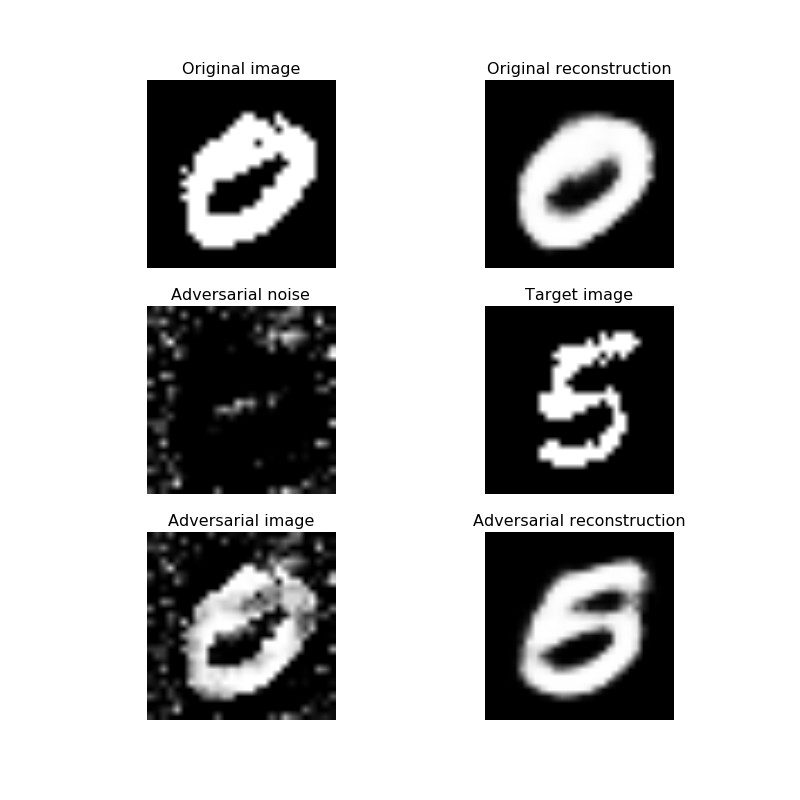

<IPython.core.display.Javascript object>


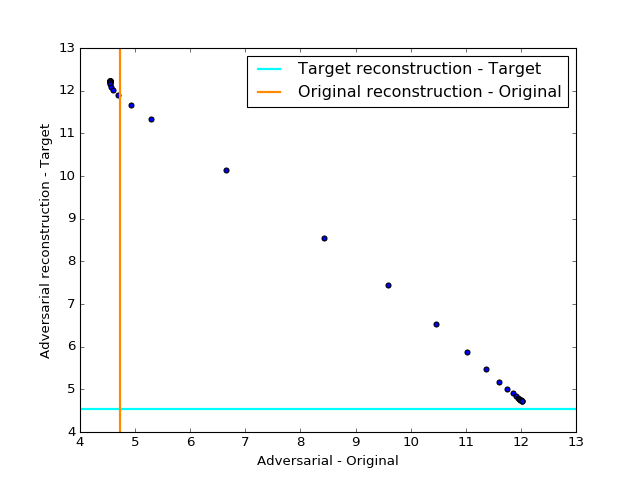

2313 6663


<IPython.core.display.Javascript object>


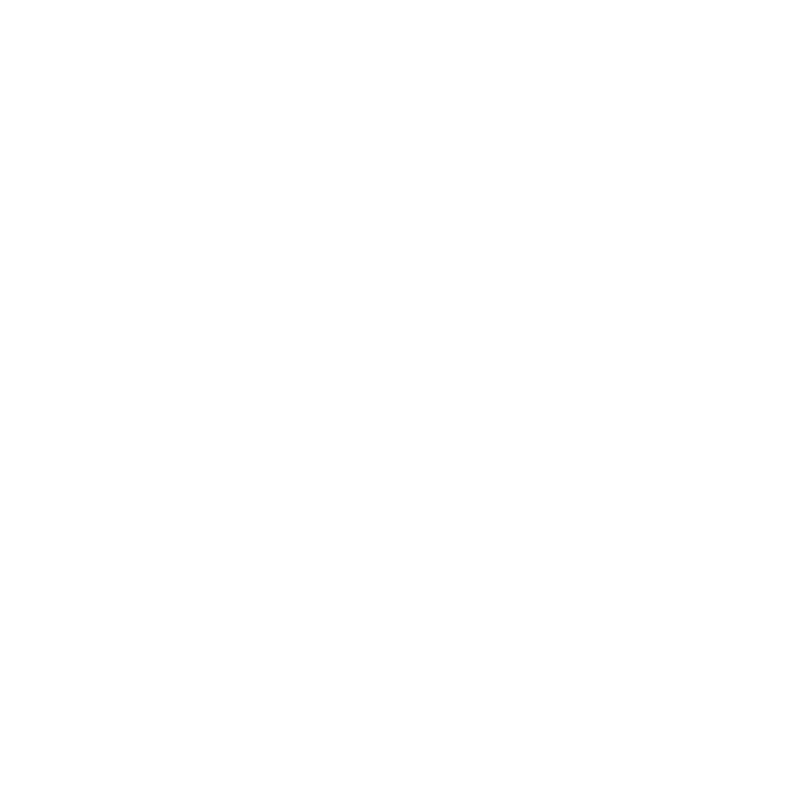

<IPython.core.display.Javascript object>


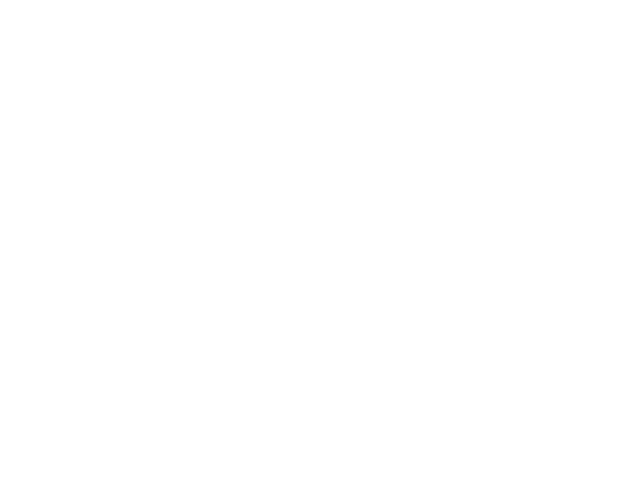

1469 9341


<IPython.core.display.Javascript object>


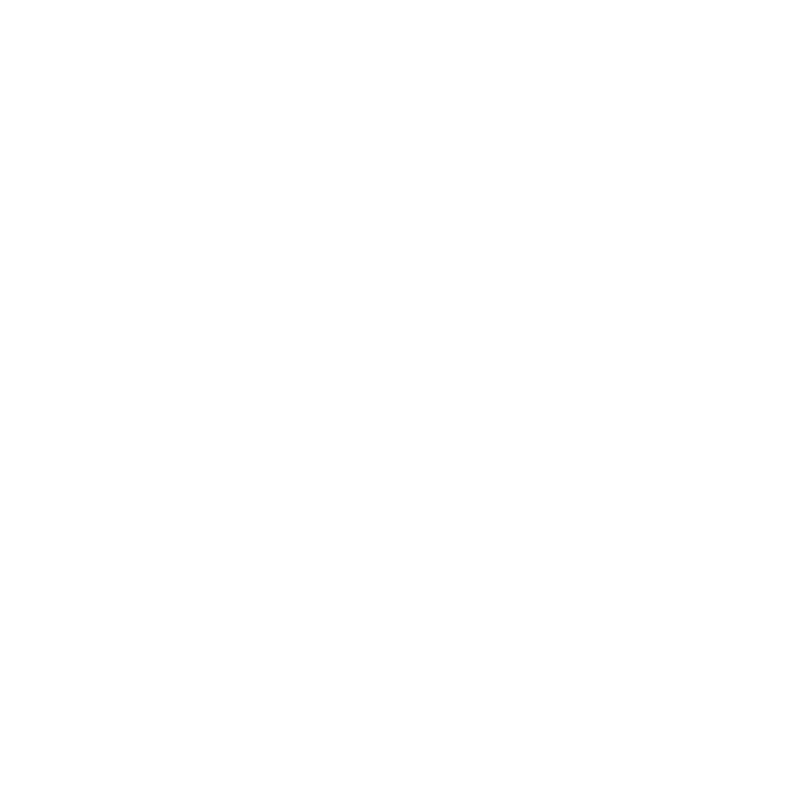

<IPython.core.display.Javascript object>


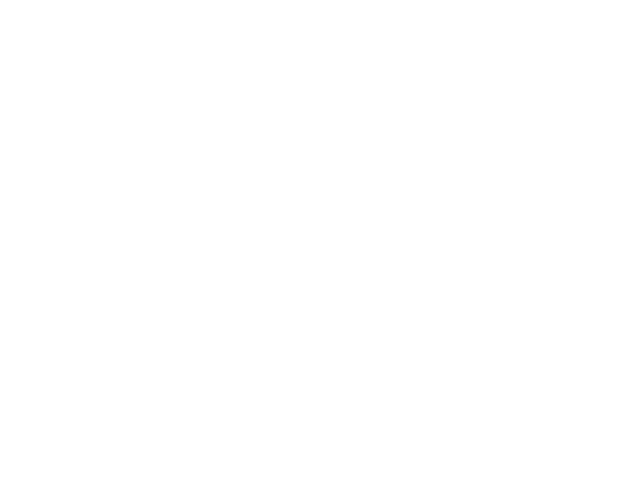

168 5117


<IPython.core.display.Javascript object>


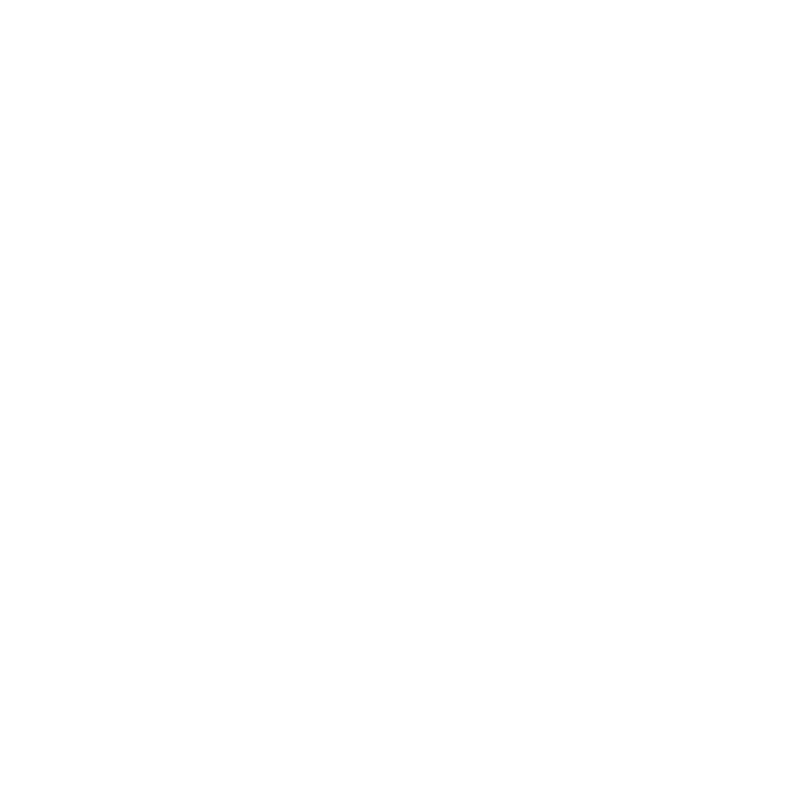

<IPython.core.display.Javascript object>


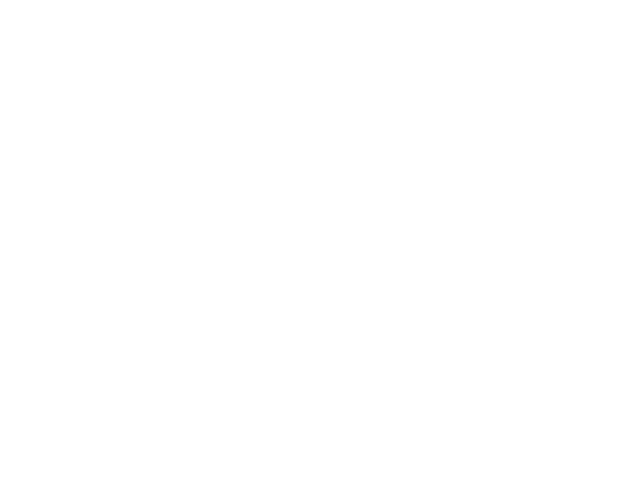

7790 5699


<IPython.core.display.Javascript object>


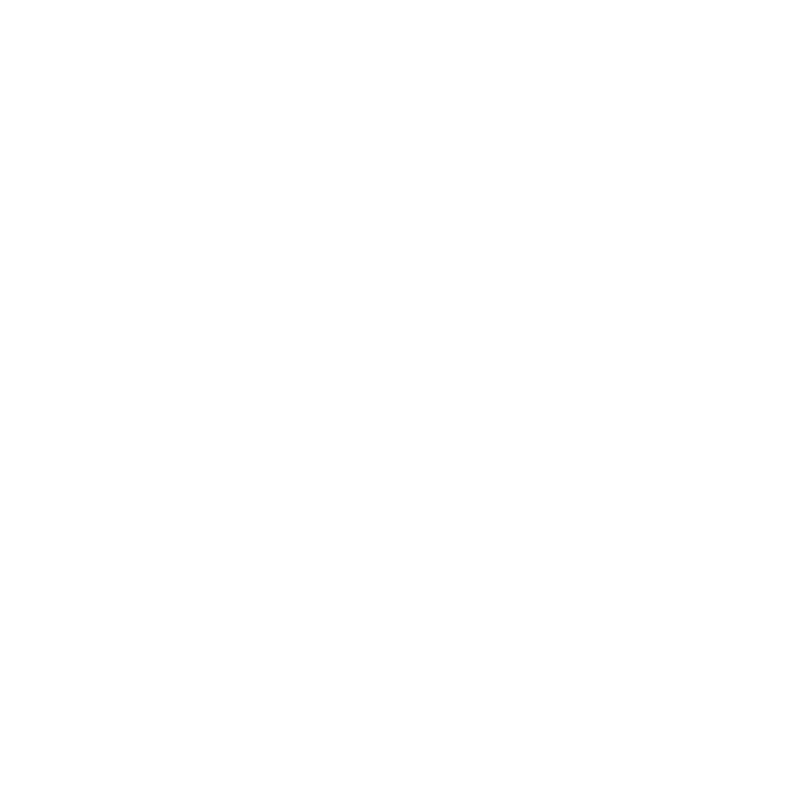

<IPython.core.display.Javascript object>


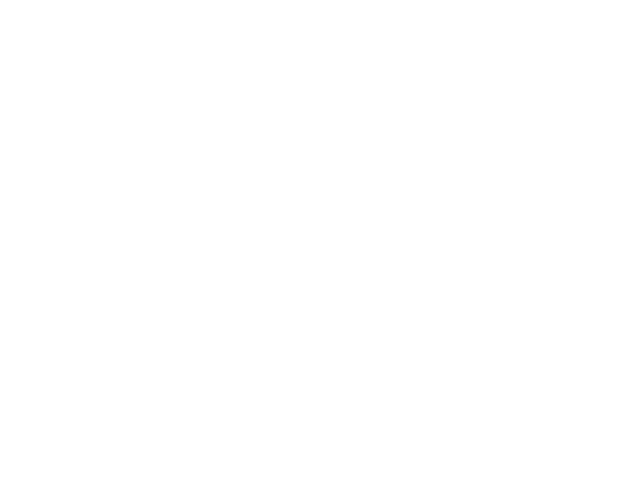

8972 3907


<IPython.core.display.Javascript object>


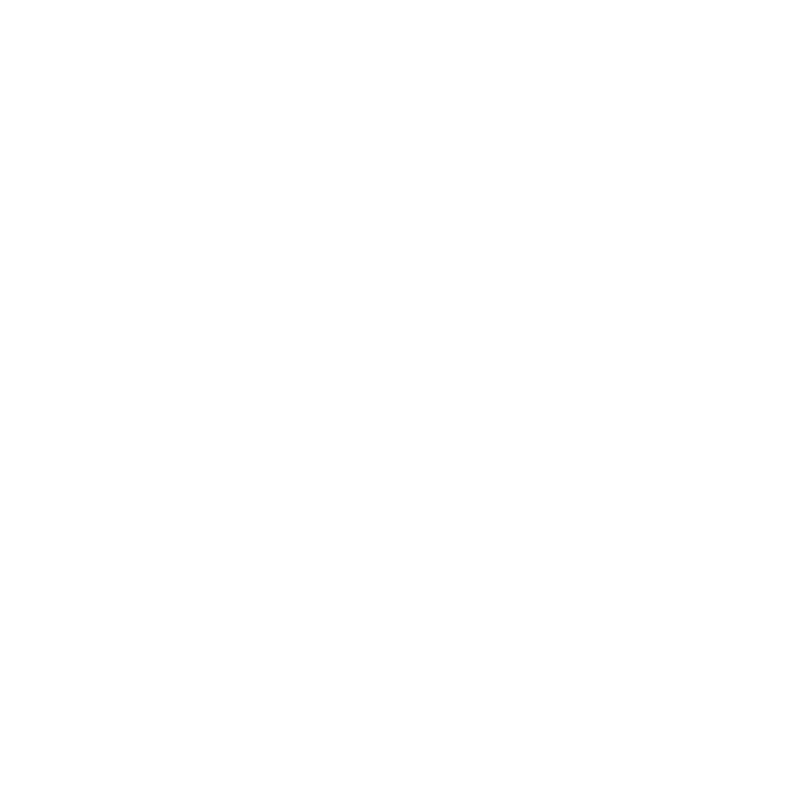

<IPython.core.display.Javascript object>


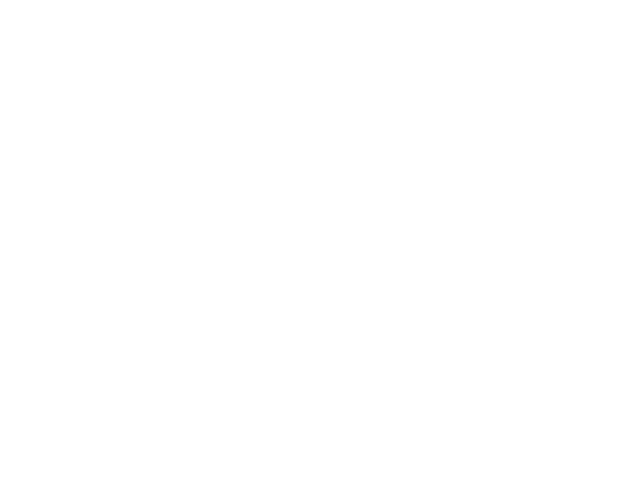

4016 6648


<IPython.core.display.Javascript object>


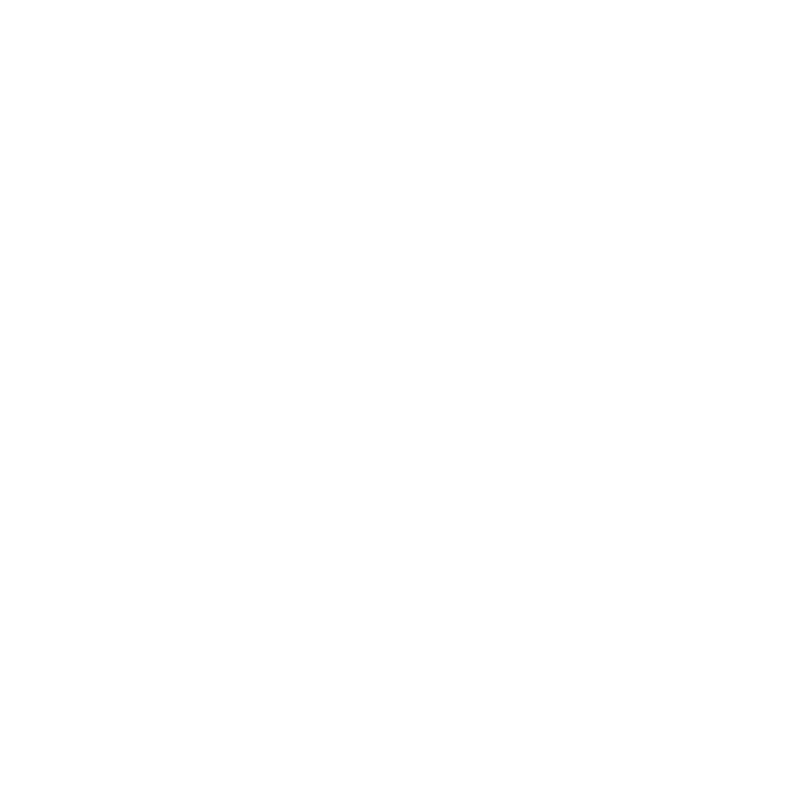

<IPython.core.display.Javascript object>


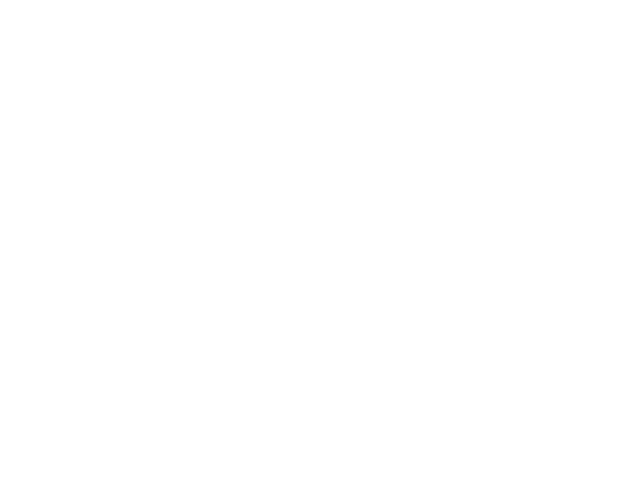

5443 3343


<IPython.core.display.Javascript object>


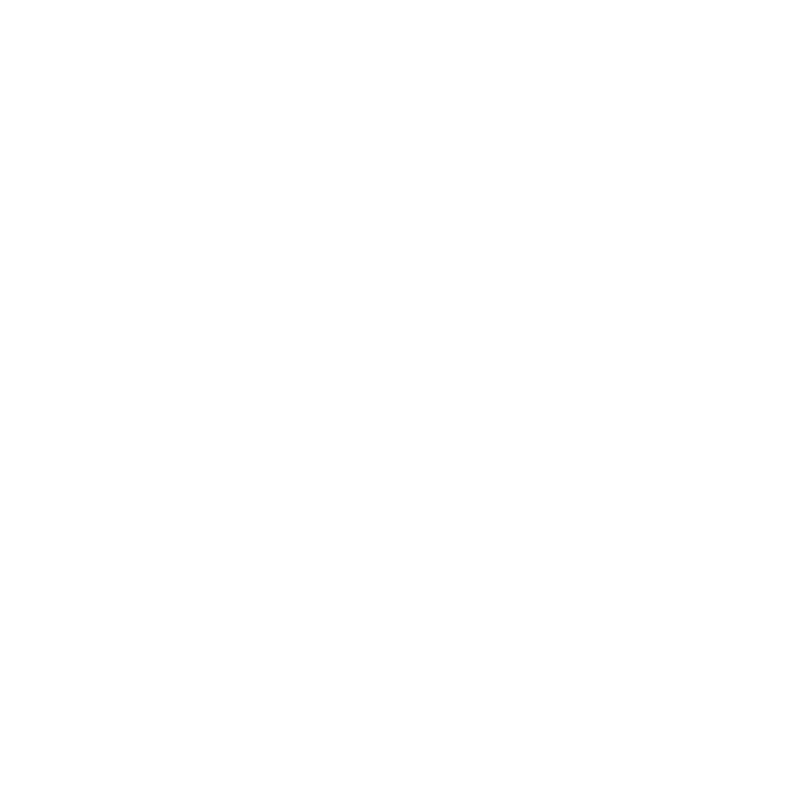

<IPython.core.display.Javascript object>


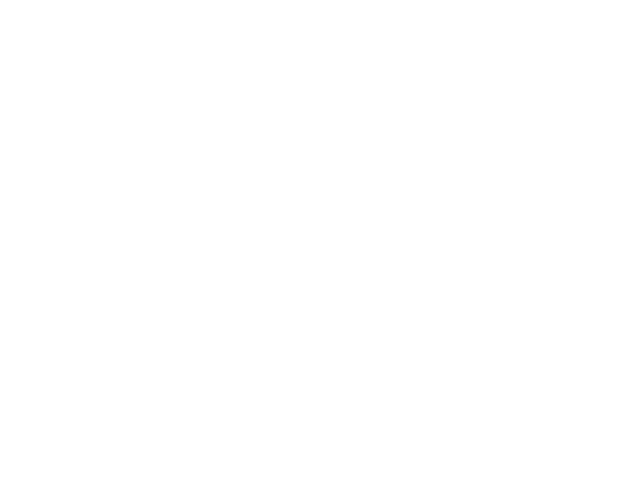

4522 7977


<IPython.core.display.Javascript object>


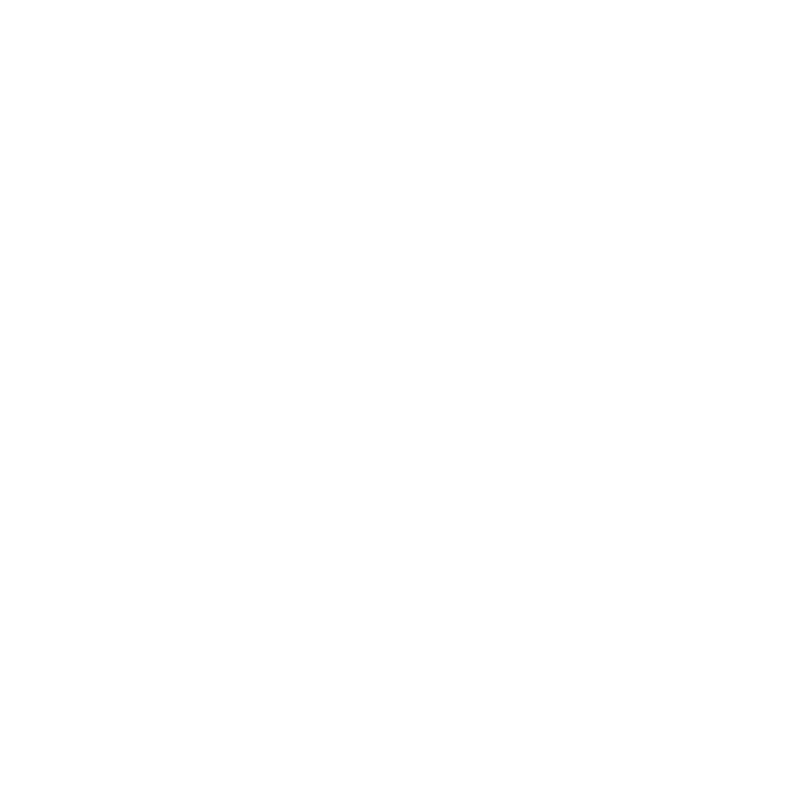

<IPython.core.display.Javascript object>


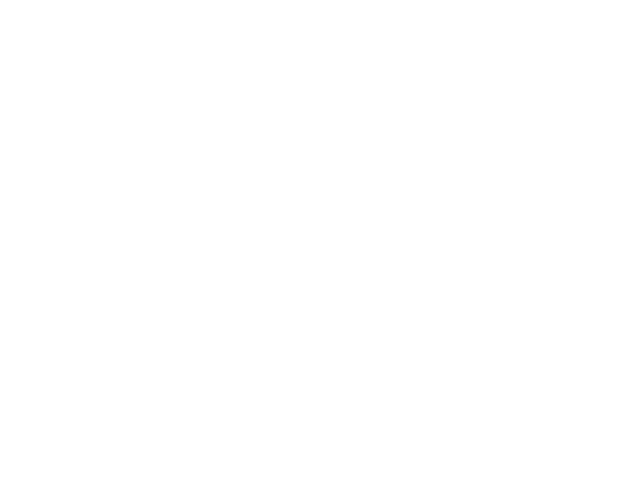

3745 9045


<IPython.core.display.Javascript object>


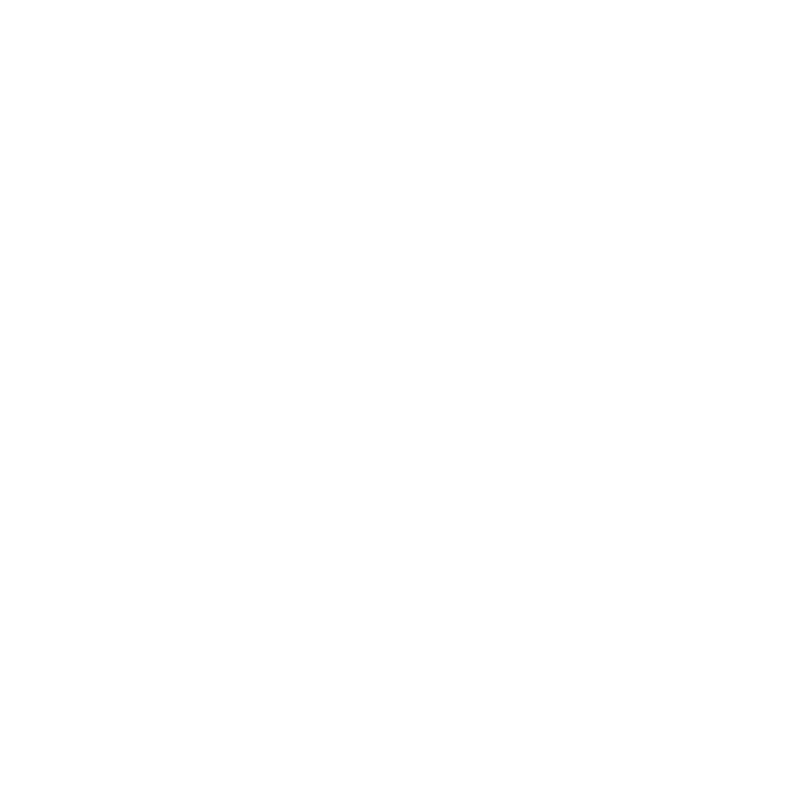

/home/tabacof/anaconda2/lib/python2.7/site-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


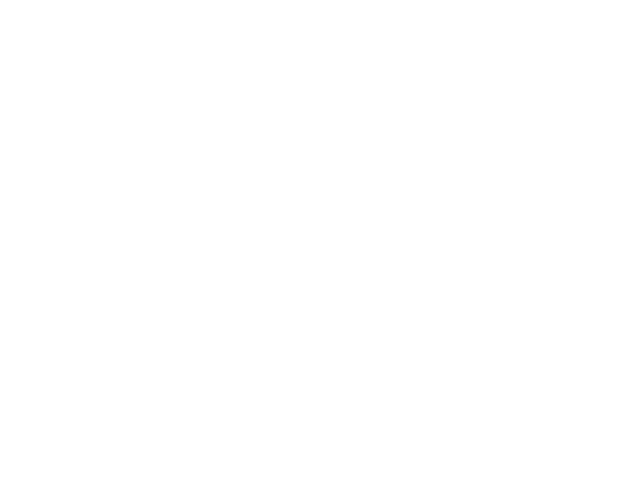

5124 4004


<IPython.core.display.Javascript object>


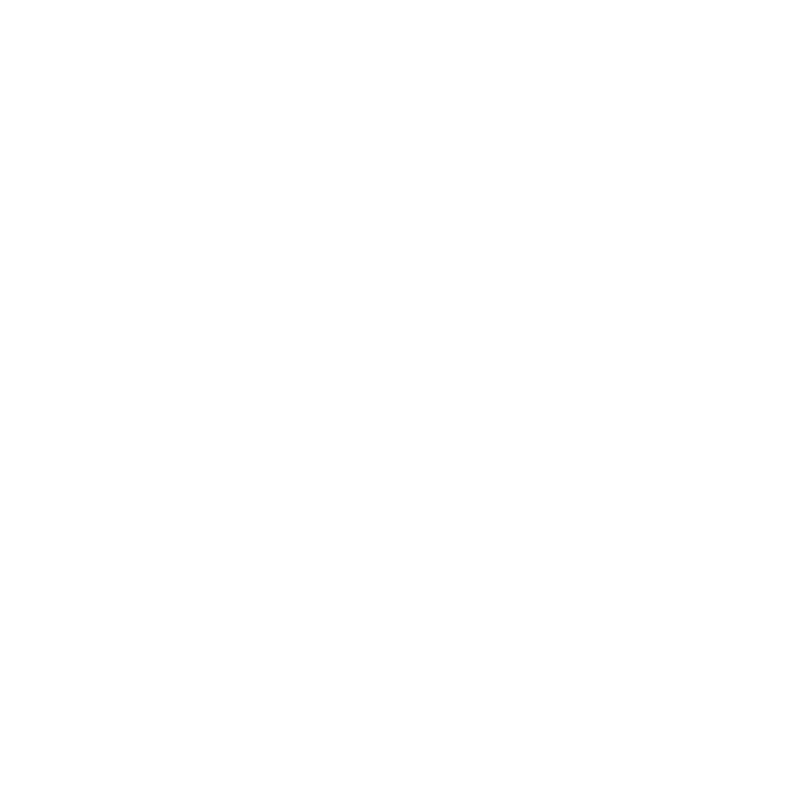

<IPython.core.display.Javascript object>


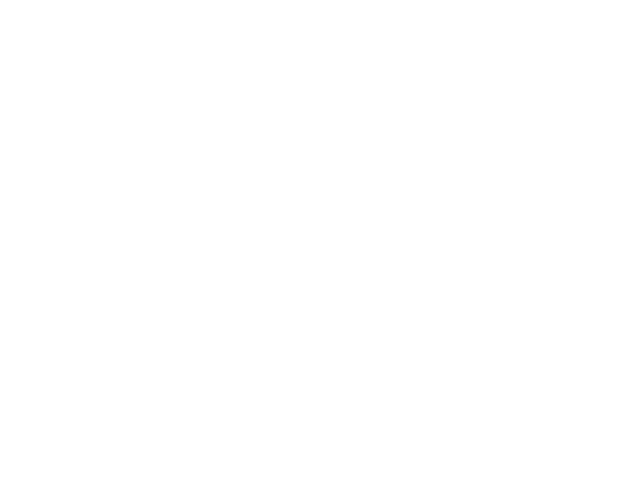

2007 4976


<IPython.core.display.Javascript object>


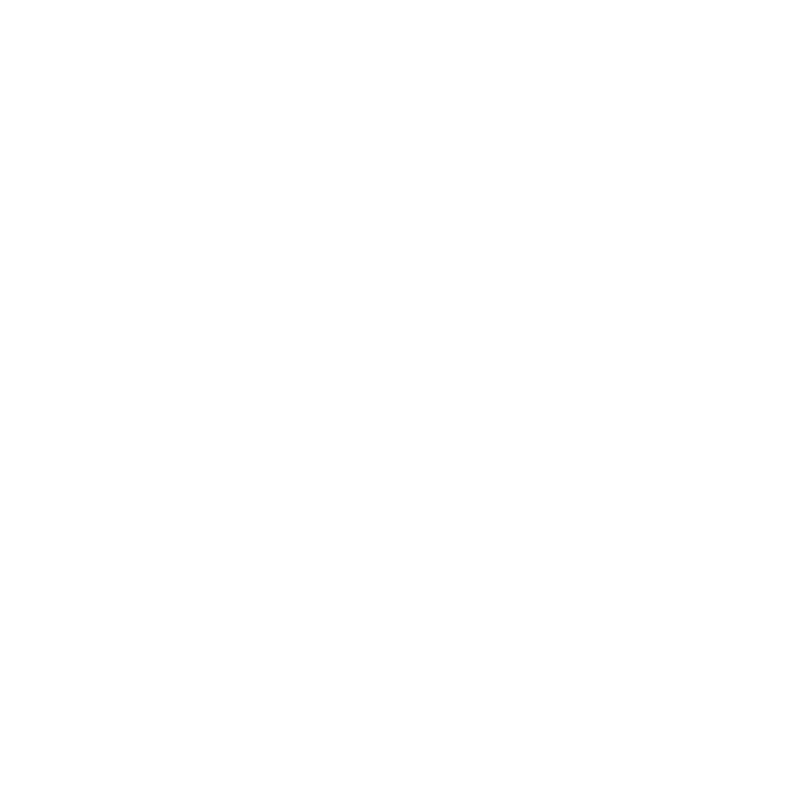

<IPython.core.display.Javascript object>


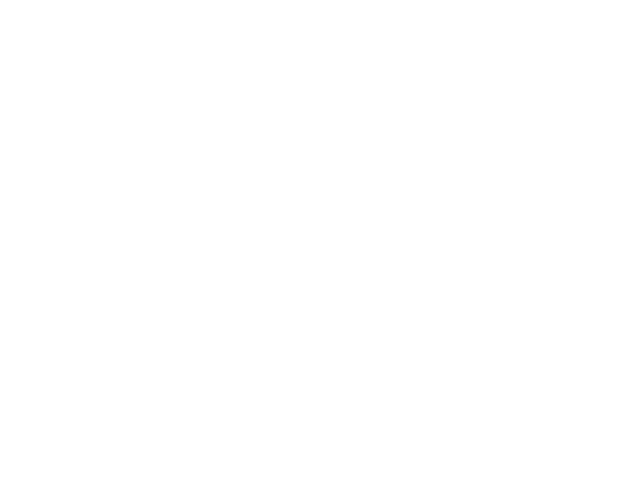

8863 9107


<IPython.core.display.Javascript object>


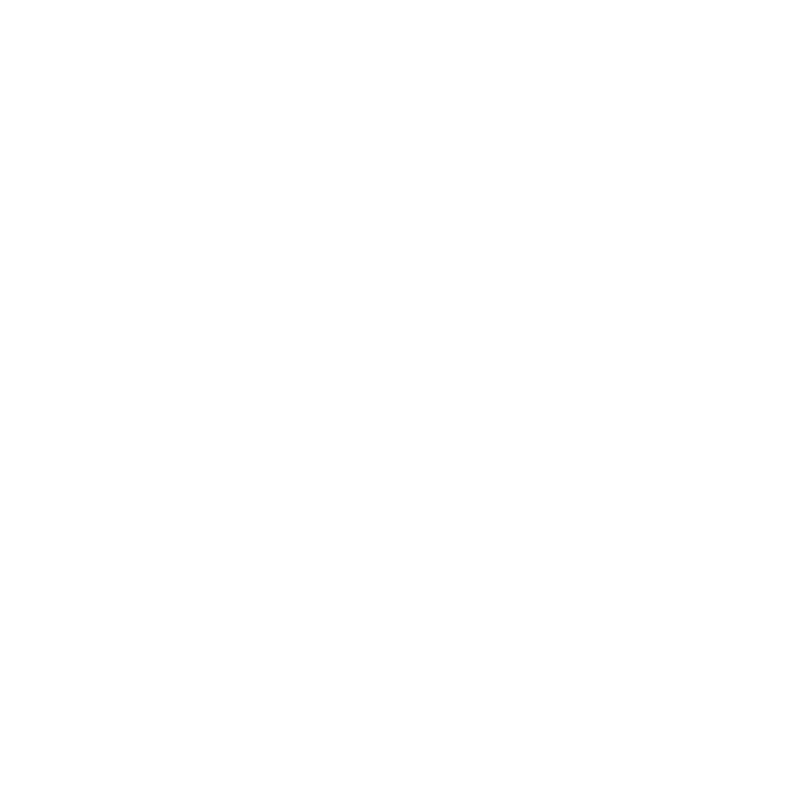

<IPython.core.display.Javascript object>


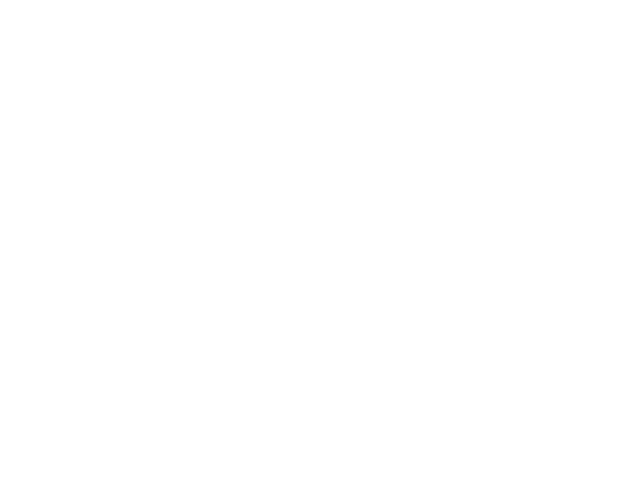

9703 3995


<IPython.core.display.Javascript object>


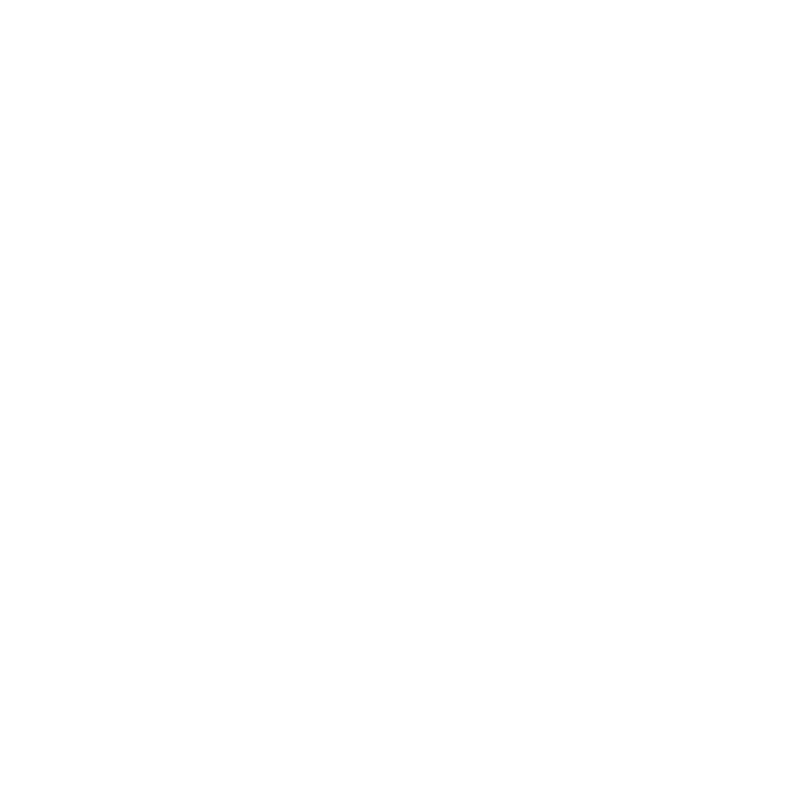

<IPython.core.display.Javascript object>


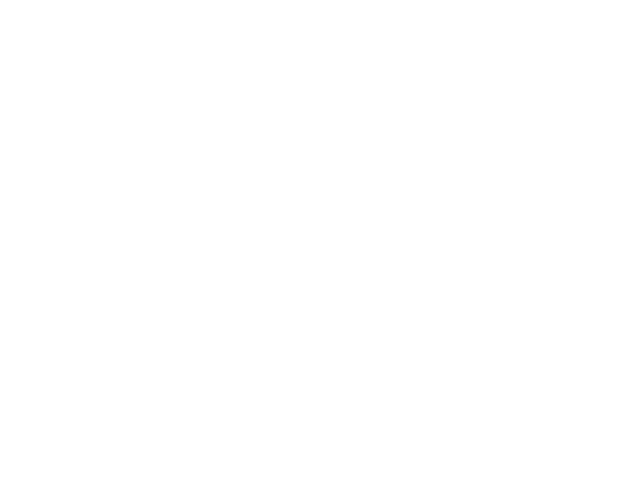

8423 2928


<IPython.core.display.Javascript object>


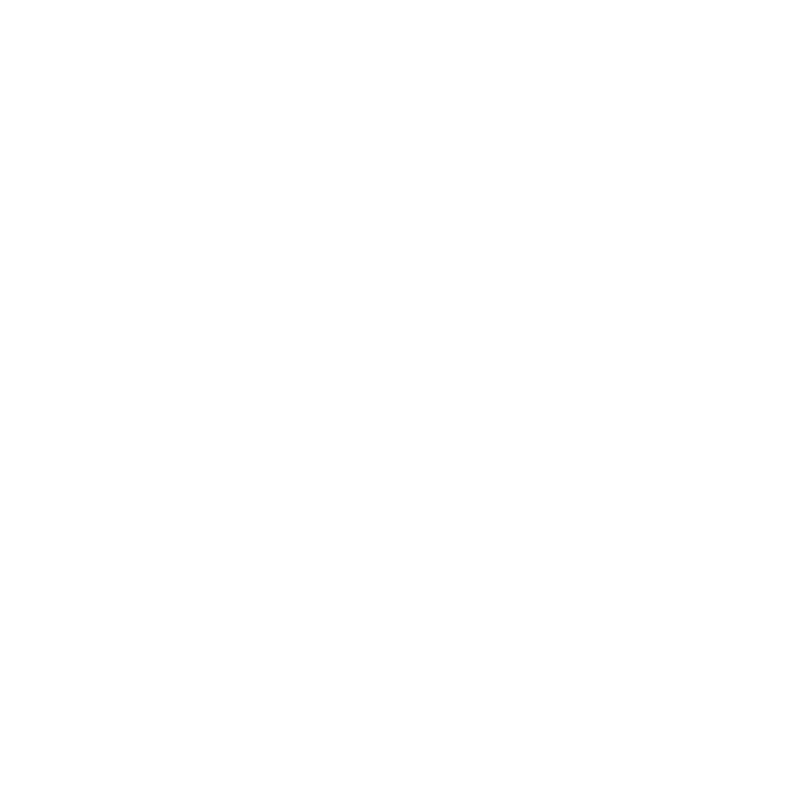

<IPython.core.display.Javascript object>


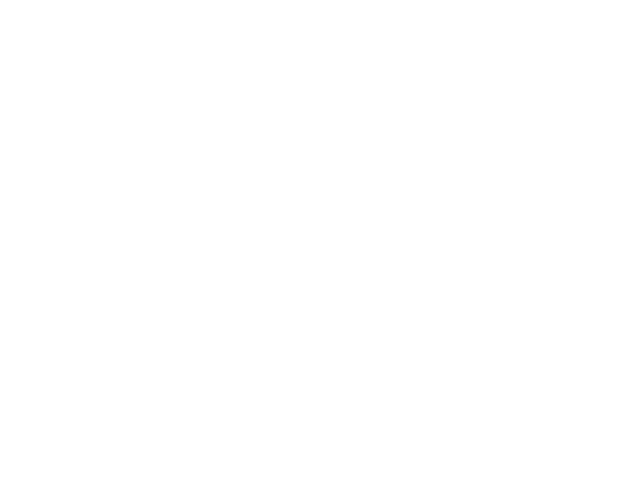

1419 8548


<IPython.core.display.Javascript object>


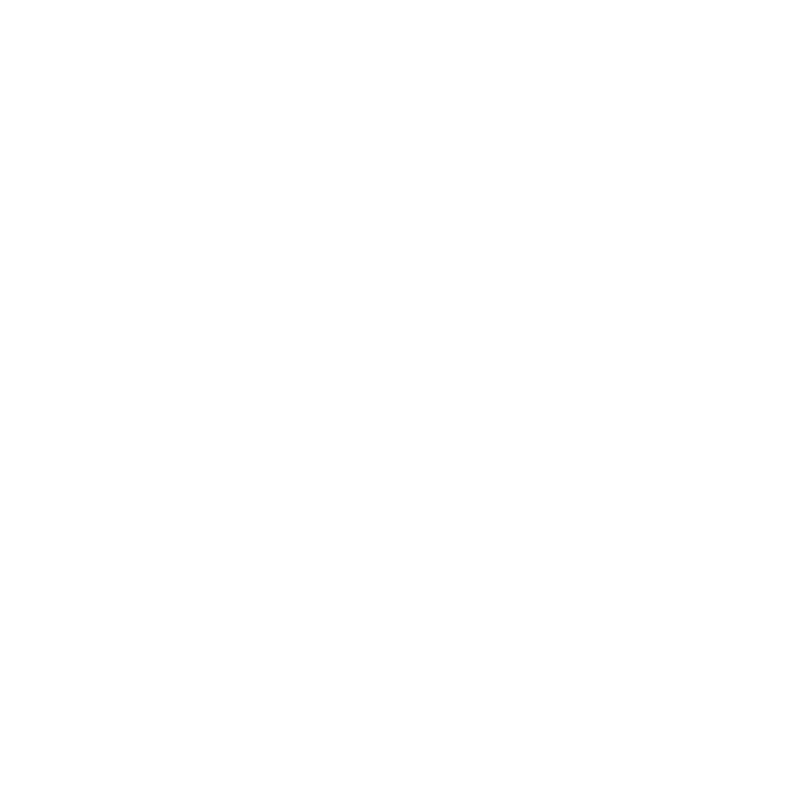

<IPython.core.display.Javascript object>


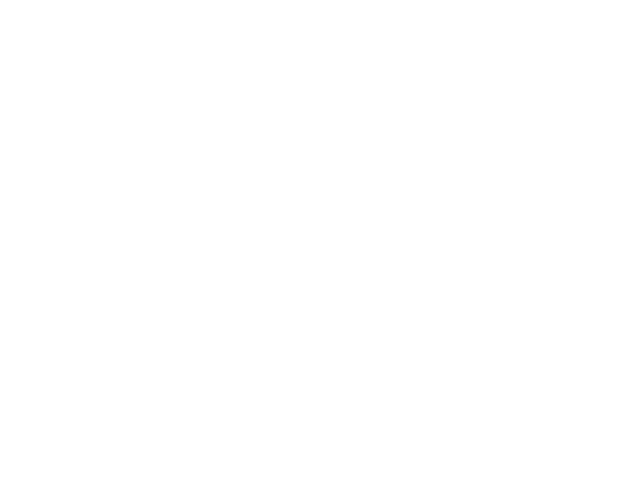

1384 1528


<IPython.core.display.Javascript object>


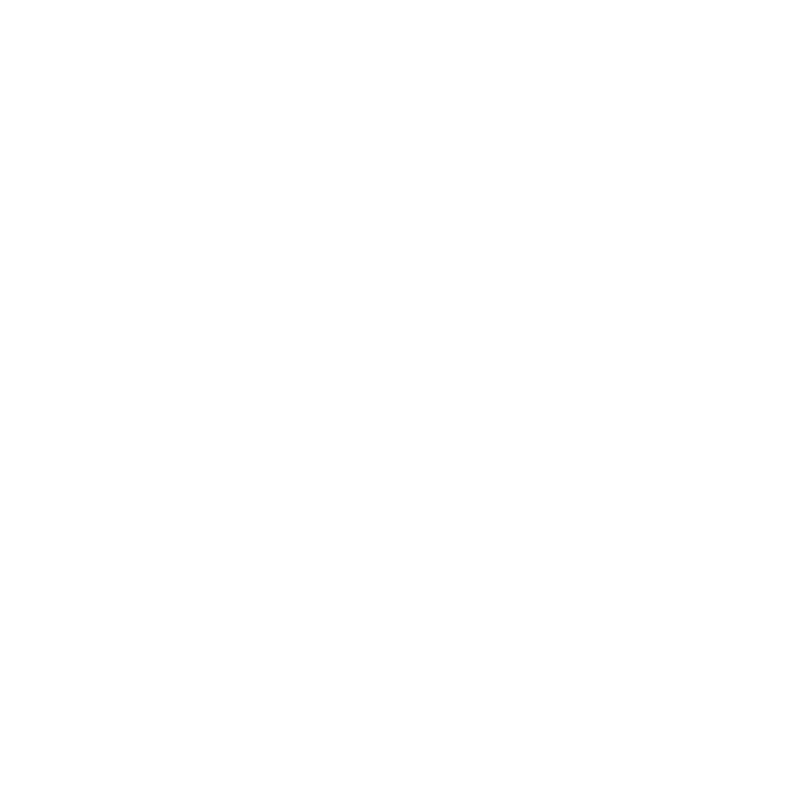

<IPython.core.display.Javascript object>


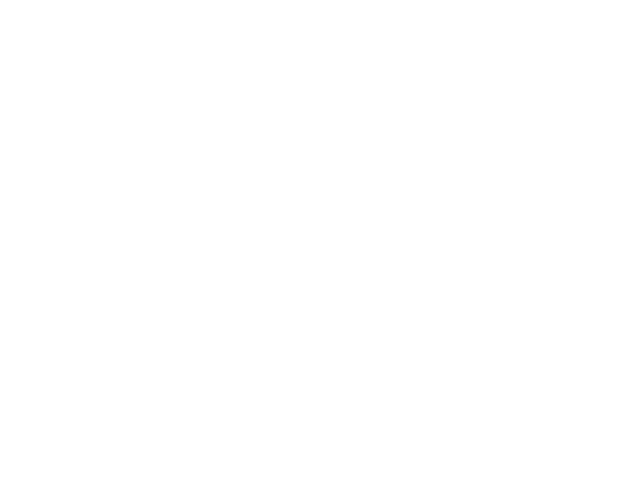

3853 1077


<IPython.core.display.Javascript object>


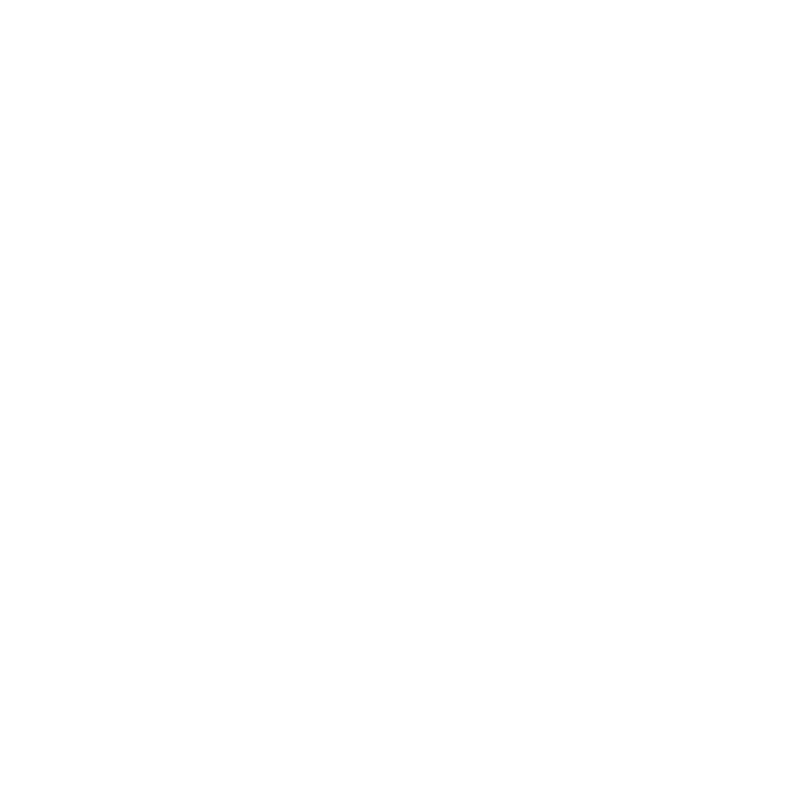

<IPython.core.display.Javascript object>


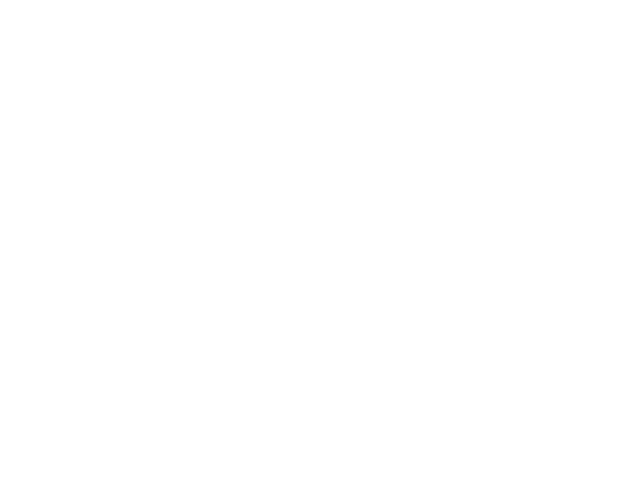

5767 9639


<IPython.core.display.Javascript object>


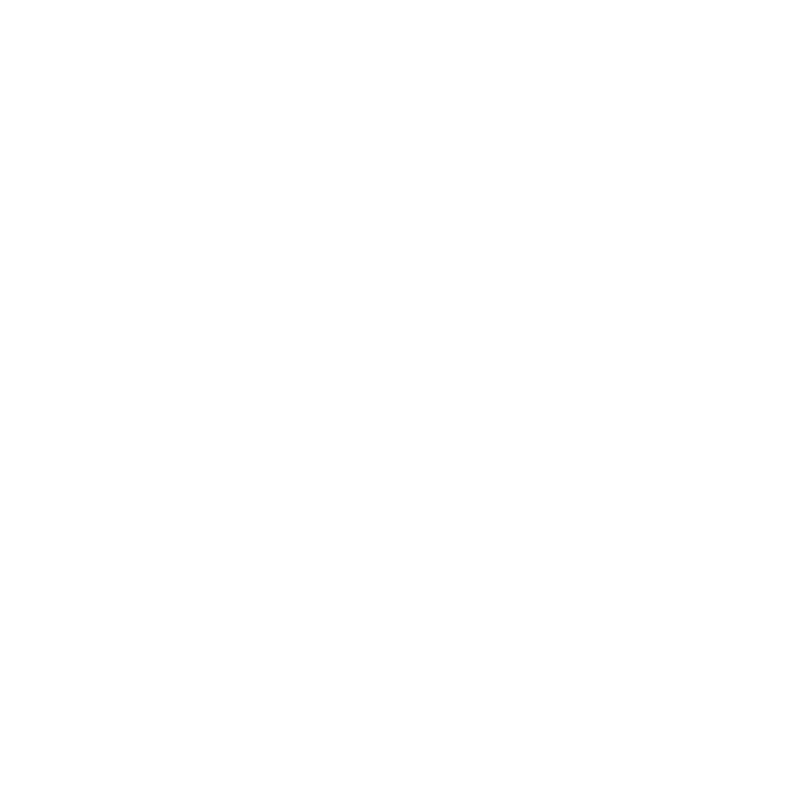

<IPython.core.display.Javascript object>


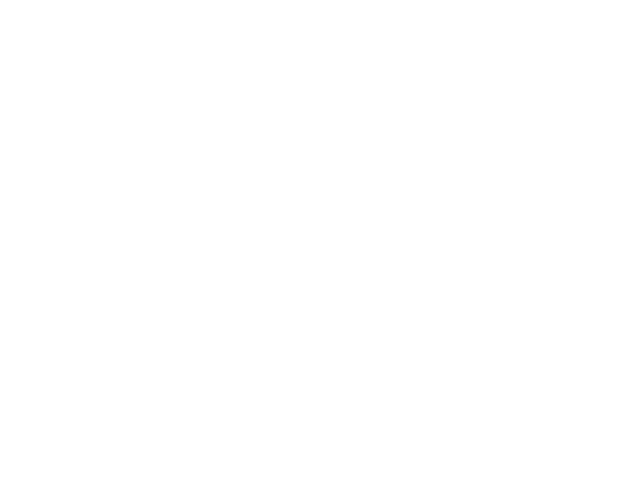

9434 238


<IPython.core.display.Javascript object>


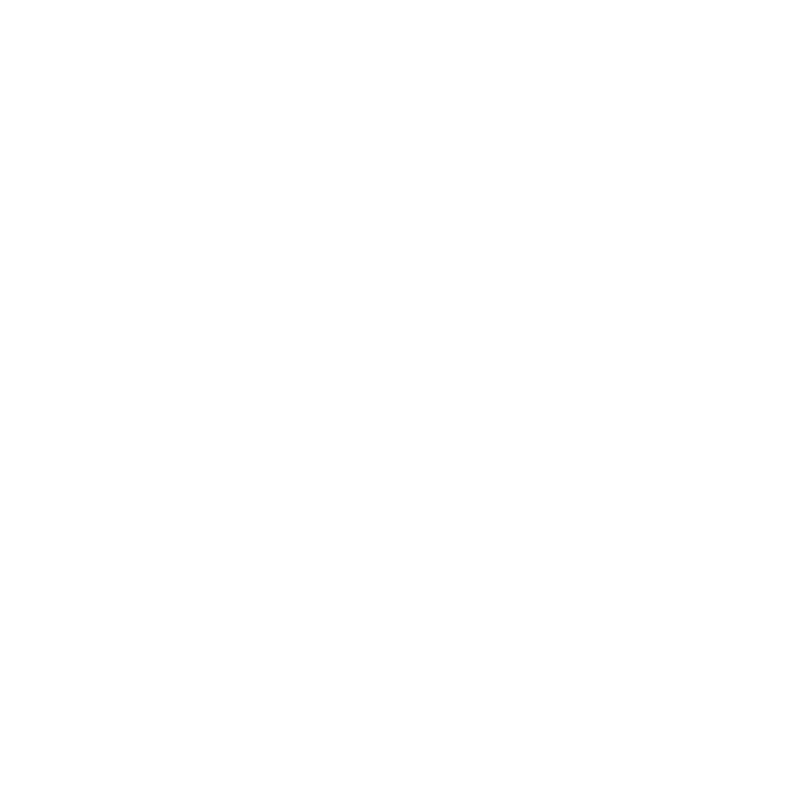

<IPython.core.display.Javascript object>


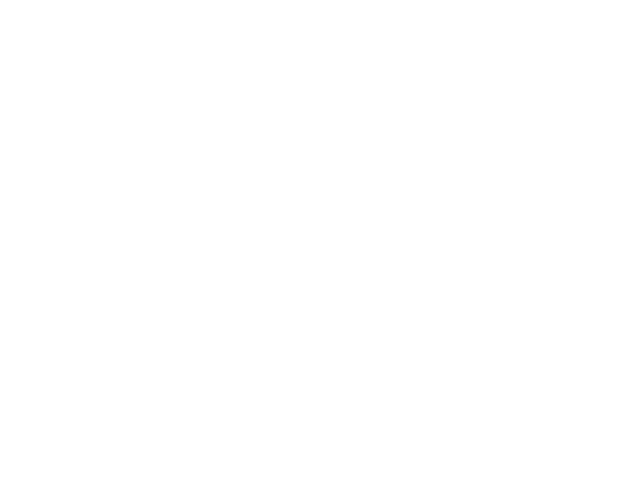

2237 7940


<IPython.core.display.Javascript object>


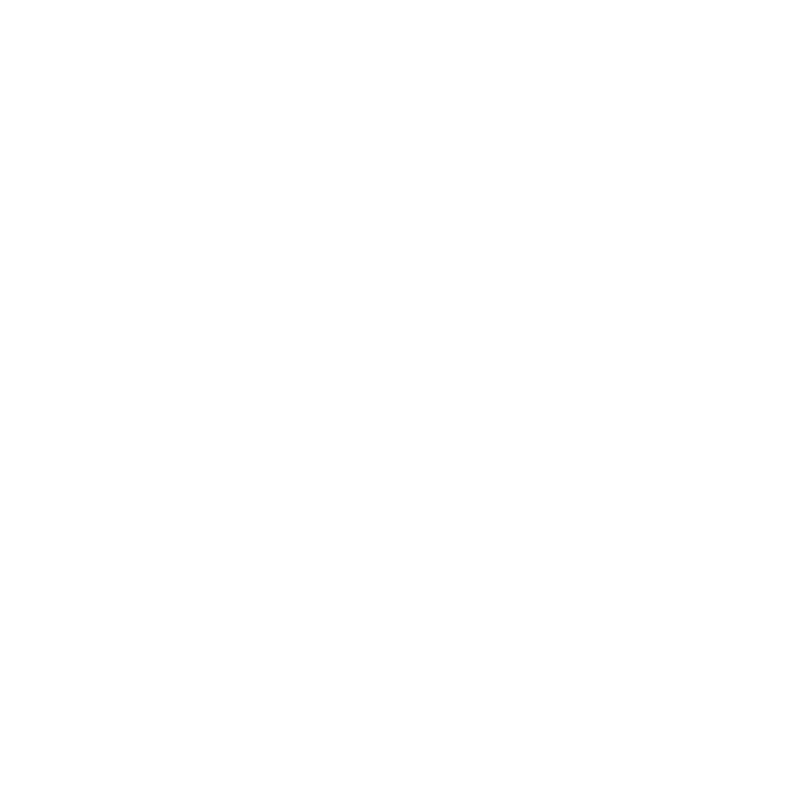

<IPython.core.display.Javascript object>


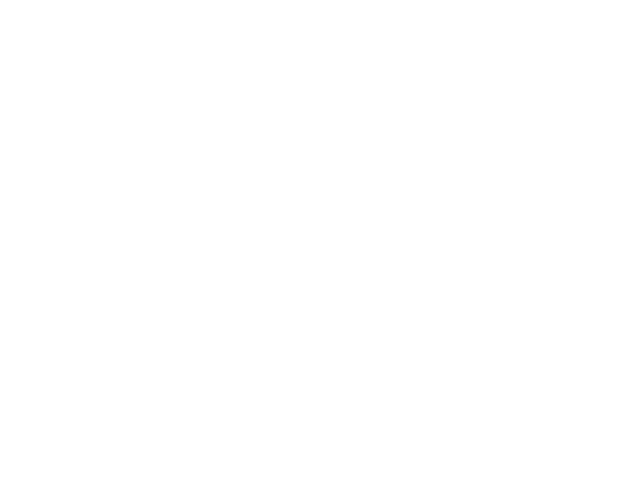

1871 7128


<IPython.core.display.Javascript object>


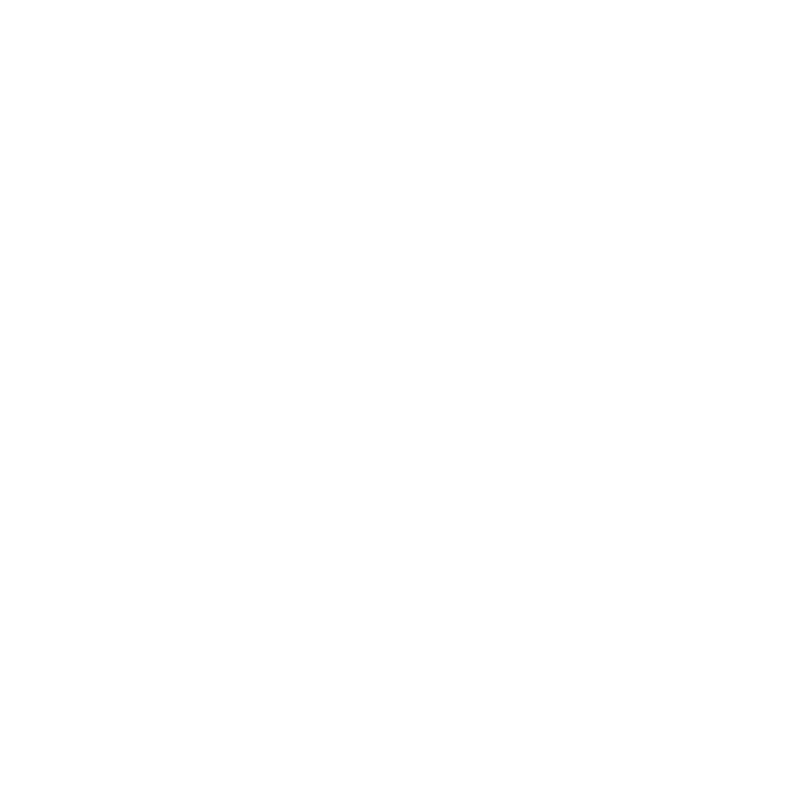

<IPython.core.display.Javascript object>


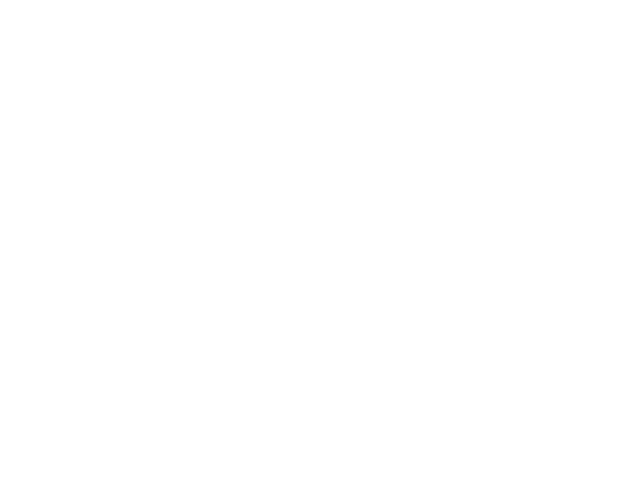

7278 5144


<IPython.core.display.Javascript object>


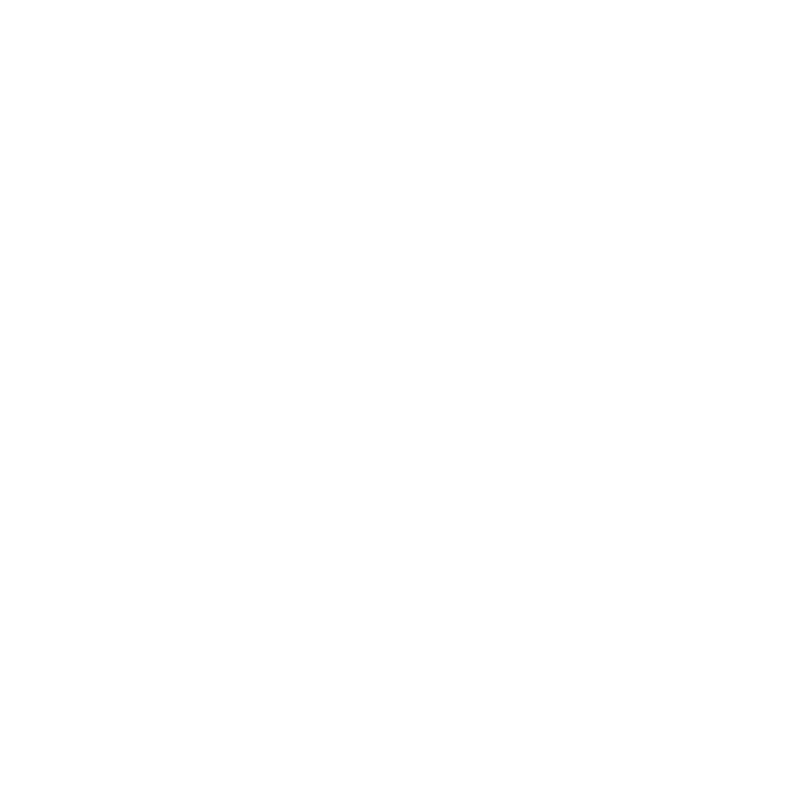

<IPython.core.display.Javascript object>


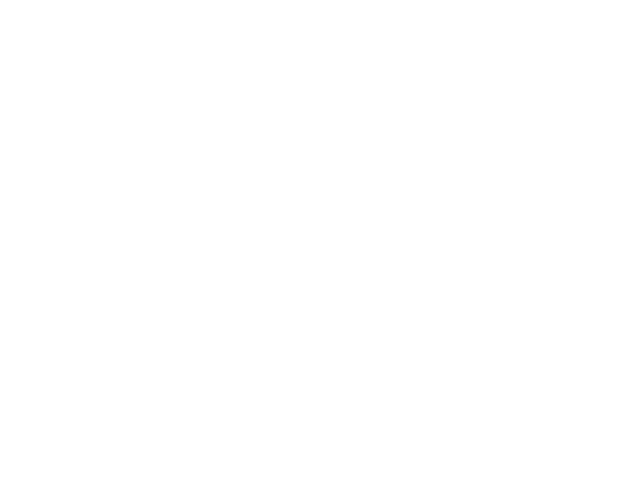

4379 2378


<IPython.core.display.Javascript object>


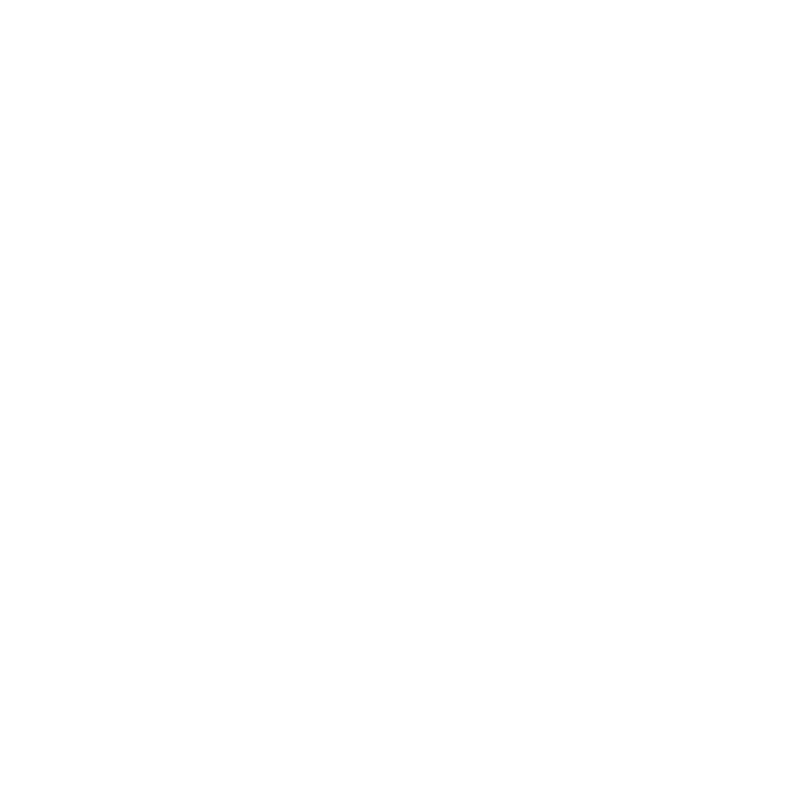

<IPython.core.display.Javascript object>


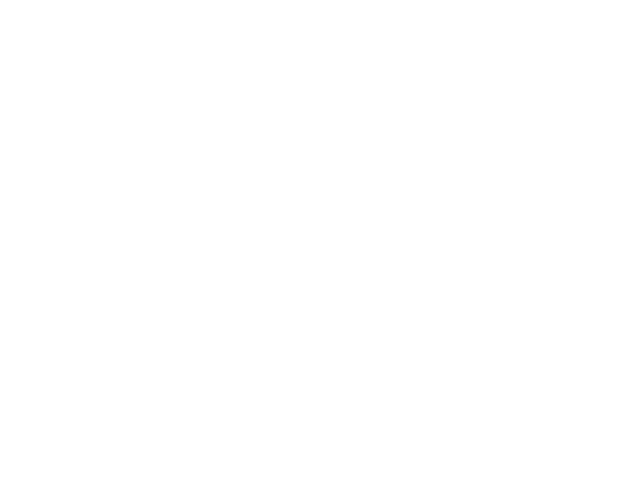

1821 6856


<IPython.core.display.Javascript object>


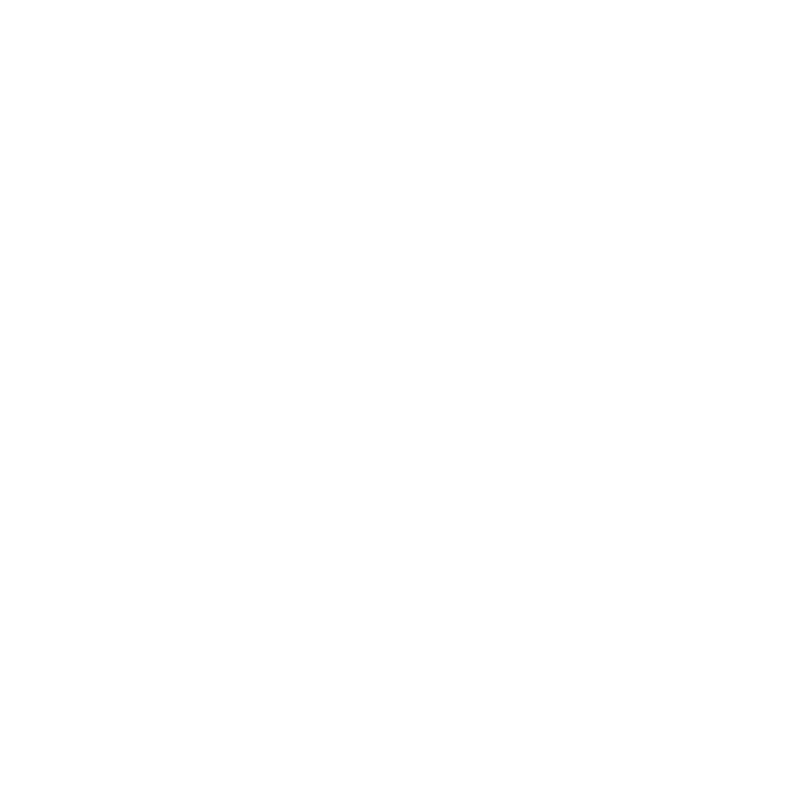

<IPython.core.display.Javascript object>


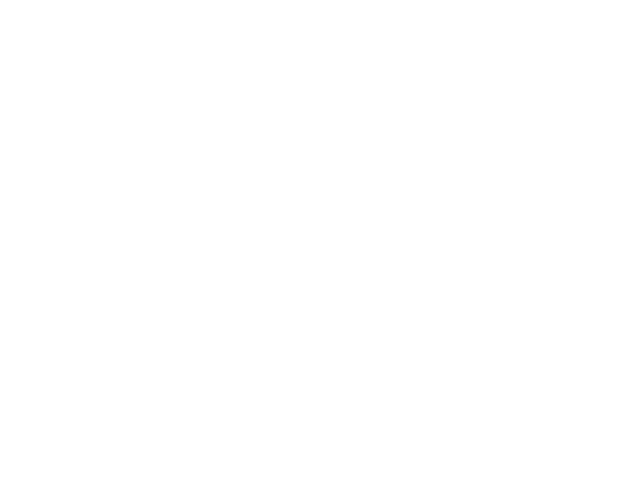

In [35]:
n = 25

xs = []
ys = []

for i in range(n):
    x, y = orig_adv_dist(plot = True)
    xs.append(x)
    ys.append(y)


<IPython.core.display.Javascript object>


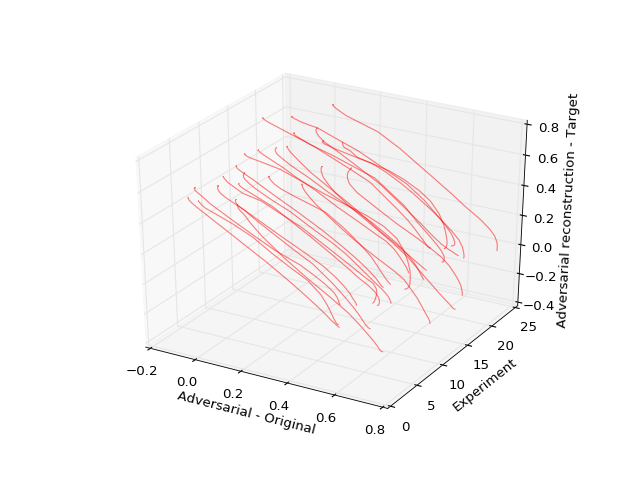

In [36]:
%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for i in range(n):
    ax.plot(xs[i], [i]*len(xs[i]), ys[i], color = 'r', alpha = 0.5)

ax.set_xlabel('Adversarial - Original')
ax.set_ylabel('Experiment')
ax.set_zlabel('Adversarial reconstruction - Target')
plt.show()